# Logistic regression

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt

import zipfile
import os
import math
import pickle
import requests
import json
import re
import logging
import seaborn

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import time
import datetime
from datetime import datetime, timedelta
from datetime import date
from dateutil import relativedelta

from io import StringIO

%matplotlib inline 
from subprocess import check_output
from IPython.display import display
from colorama import Fore, Back, Style
from scipy.stats import pearsonr

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.utils import shuffle
from sklearn import linear_model
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler 
from sklearn import datasets

import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras import optimizers
from keras import losses


In [85]:
data = pd.read_csv('preprocessed_data.csv')

In [6]:
data

,Route,Min Gap,Vehicle,Delay,Direction_e,Direction_n,Direction_s,Direction_w,Incident_Diversion,Incident_Emergency Services,...,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Year,Month,Day,Hour
0,505,8,4018,1,1,0,0,0,0,0,...,0,0,0,1,0,0,2014,1,2,6
1,504,22,4128,1,1,0,0,0,0,0,...,0,0,0,1,0,0,2014,1,2,12
2,501,19,4016,1,0,0,0,1,0,0,...,0,0,0,1,0,0,2014,1,2,14
3,504,11,4175,1,0,0,0,1,0,0,...,0,0,0,1,0,0,2014,1,2,14
4,504,6,4080,1,1,0,0,0,0,0,...,0,0,0,1,0,0,2014,1,2,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45039,505,16,4164,1,1,0,0,0,0,0,...,0,0,1,0,0,0,2017,12,31,9
45040,501,24,4110,1,0,0,0,1,0,0,...,0,0,1,0,0,0,2017,12,31,11
45041,501,24,1419,1,0,0,0,1,0,0,...,0,0,1,0,0,0,2017,12,31,11
45042,510,10,4447,1,0,0,1,0,0,0,...,0,0,1,0,0,0,2017,12,31,11


In [9]:
feature_names = data.columns

for col in feature_names:
     print(col)

Route
Min Gap
Vehicle
Delay
Direction_e
Direction_n
Direction_s
Direction_w
Incident_Diversion
Incident_Emergency Services
Incident_General Delay
Incident_Held By
Incident_Investigation
Incident_Late Leaving Garage
Incident_Mechanical
Incident_Overhead - Pantograph
Incident_Utilized Off Route
Day_Friday
Day_Monday
Day_Saturday
Day_Sunday
Day_Thursday
Day_Tuesday
Day_Wednesday
Year
Month
Day
Hour


In [10]:
corrcoefs = data.corr()['Delay']
corrcoefs

Route                            -0.008716
Min Gap                           0.056566
Vehicle                           0.001145
Delay                             1.000000
Direction_e                       0.011842
Direction_n                      -0.023678
Direction_s                      -0.020946
Direction_w                       0.012471
Incident_Diversion               -0.023048
Incident_Emergency Services       0.001560
Incident_General Delay           -0.060980
Incident_Held By                  0.030531
Incident_Investigation           -0.014389
Incident_Late Leaving Garage      0.017236
Incident_Mechanical               0.014905
Incident_Overhead - Pantograph    0.001530
Incident_Utilized Off Route      -0.023245
Day_Friday                       -0.008207
Day_Monday                        0.005826
Day_Saturday                      0.000255
Day_Sunday                       -0.000565
Day_Thursday                     -0.005024
Day_Tuesday                      -0.000402
Day_Wednesd

In [11]:
# corrcoefs_for_barh = ( (corrcoefs.drop('Delay')) * 1000000 ).astype(int)
corrcoefs_for_barh = corrcoefs.drop('Delay')
corrcoefs_for_barh


Route                            -0.008716
Min Gap                           0.056566
Vehicle                           0.001145
Direction_e                       0.011842
Direction_n                      -0.023678
Direction_s                      -0.020946
Direction_w                       0.012471
Incident_Diversion               -0.023048
Incident_Emergency Services       0.001560
Incident_General Delay           -0.060980
Incident_Held By                  0.030531
Incident_Investigation           -0.014389
Incident_Late Leaving Garage      0.017236
Incident_Mechanical               0.014905
Incident_Overhead - Pantograph    0.001530
Incident_Utilized Off Route      -0.023245
Day_Friday                       -0.008207
Day_Monday                        0.005826
Day_Saturday                      0.000255
Day_Sunday                       -0.000565
Day_Thursday                     -0.005024
Day_Tuesday                      -0.000402
Day_Wednesday                     0.008324
Year       

IndexError: arrays used as indices must be of integer (or boolean) type

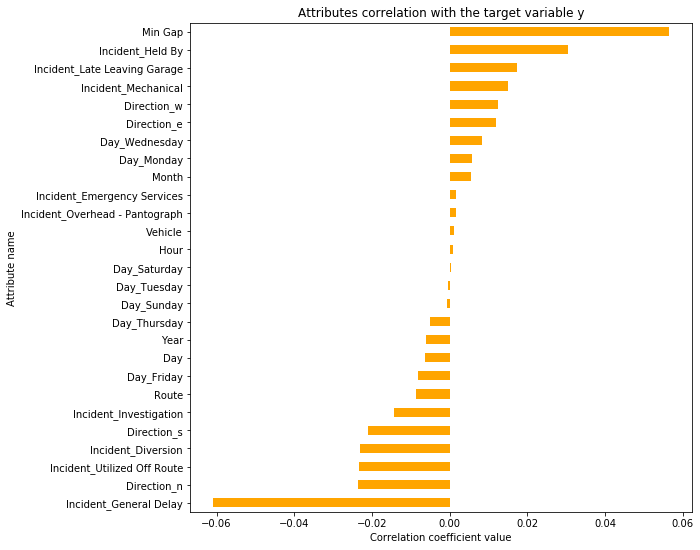

In [12]:
number_of_features = len(data.columns)

coefs_for_plot = pd.Series(corrcoefs_for_barh).sort_values()
coefs_for_plot.plot(kind = "barh", color = 'orange', figsize = (9, 9))

plt.title("Attributes correlation with the target variable y" )
plt.ylabel('Attribute name')
plt.xlabel('Correlation coefficient value')
plt.yticks(np.arange(number_of_features), list(feature_names[coefs_for_plot.index]))
plt.plot()

In [86]:
y = data['Delay']
X = data.drop(columns=['Delay'])

In [14]:
X.corr()

,Route,Min Gap,Vehicle,Direction_e,Direction_n,Direction_s,Direction_w,Incident_Diversion,Incident_Emergency Services,Incident_General Delay,...,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Year,Month,Day,Hour
Route,1.000000,-0.086860,0.003536,-0.019117,0.064304,0.058385,-0.047580,-0.023700,-0.055631,0.017453,...,0.010611,-0.029604,-0.049578,0.015163,0.009791,0.024823,-0.011980,-0.001899,0.011446,-0.000178
Min Gap,-0.086860,1.000000,-0.020061,-0.018443,-0.031929,-0.017381,0.045133,0.175230,0.048142,0.010307,...,-0.013045,0.015613,0.042096,-0.015156,-0.005897,-0.009730,-0.015375,0.016159,-0.001196,-0.005060
Vehicle,0.003536,-0.020061,1.000000,0.015028,-0.001610,0.000429,-0.014221,-0.002160,0.001392,-0.024807,...,-0.002274,-0.004080,-0.003524,-0.002267,0.008051,0.001761,-0.049402,0.001179,-0.001149,0.000911
Direction_e,-0.019117,-0.018443,0.015028,1.000000,-0.247167,-0.235475,-0.728888,-0.018901,-0.012847,-0.022736,...,-0.004201,-0.007830,-0.005333,0.004471,0.012275,0.000122,-0.008377,-0.030390,-0.010049,0.003917
Direction_n,0.064304,-0.031929,-0.001610,-0.247167,1.000000,-0.084908,-0.262825,-0.001596,-0.012627,-0.015004,...,-0.004585,0.009142,0.001315,0.000321,-0.004783,0.003262,-0.003167,-0.001273,-0.010484,-0.002060
Direction_s,0.058385,-0.017381,0.000429,-0.235475,-0.084908,1.000000,-0.250392,-0.002825,-0.005542,-0.020404,...,0.006021,0.005678,0.006880,-0.007091,-0.009010,-0.002902,-0.005430,0.008200,0.000749,0.002629
Direction_w,-0.047580,0.045133,-0.014221,-0.728888,-0.262825,-0.250392,1.000000,0.021100,0.022643,0.041636,...,0.003501,-0.000309,0.000905,-0.000843,-0.004734,-0.000384,0.012928,0.026452,0.015350,-0.004136
Incident_Diversion,-0.023700,0.175230,-0.002160,-0.018901,-0.001596,-0.002825,0.021100,1.000000,-0.020563,-0.022316,...,-0.005460,0.002509,0.026506,-0.002049,-0.000388,-0.006262,0.009340,0.011782,-0.000767,0.001514
Incident_Emergency Services,-0.055631,0.048142,0.001392,-0.012847,-0.012627,-0.005542,0.022643,-0.020563,1.000000,-0.032508,...,-0.008074,0.017137,0.026137,-0.005801,-0.007367,-0.006865,0.018482,-0.000305,-0.007546,-0.008458
Incident_General Delay,0.017453,0.010307,-0.024807,-0.022736,-0.015004,-0.020404,0.041636,-0.022316,-0.032508,1.000000,...,-0.020637,0.010302,0.018267,0.003729,-0.014024,-0.001173,0.038061,0.021885,0.013049,-0.000141


In [15]:
number_of_features = X.shape[1]

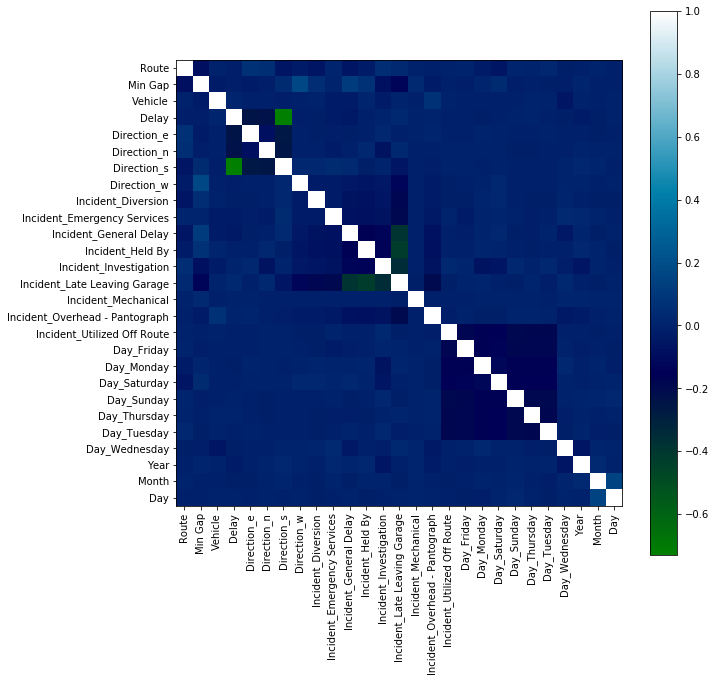

In [16]:
plt.figure(figsize = (10, 10))
plt.xticks(range(0, number_of_features), feature_names, rotation='vertical')
plt.yticks(range(0, number_of_features), feature_names)
plt.imshow(X.corr(), cmap='ocean')
plt.colorbar()
plt.show()

In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.33, random_state = 7, stratify = y)

In [18]:
X_train

,Route,Min Gap,Vehicle,Direction_e,Direction_n,Direction_s,Direction_w,Incident_Diversion,Incident_Emergency Services,Incident_General Delay,...,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Year,Month,Day,Hour
40978,506,12,4169,1,0,0,0,0,0,0,...,0,0,0,1,0,0,2017,7,27,17
29934,501,10,4221,0,0,0,1,0,0,0,...,0,0,0,0,0,1,2016,9,21,22
12501,504,8,4038,1,0,0,0,0,0,0,...,0,0,0,0,1,0,2015,2,24,6
7718,504,8,4153,1,0,0,0,0,0,0,...,0,0,0,1,0,0,2014,10,2,10
41369,506,1,4035,0,0,0,1,0,0,0,...,0,0,0,1,0,0,2017,8,10,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27651,501,29,4205,1,0,0,0,0,0,0,...,0,0,0,0,1,0,2016,7,5,8
43907,501,10,4232,0,0,0,1,0,0,0,...,0,0,0,0,0,1,2017,12,6,14
26054,512,74,4183,0,0,0,1,0,0,0,...,0,1,0,0,0,0,2016,5,14,8
31049,503,24,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,2016,10,26,8


In [19]:
X_train.shape

(30179, 27)

In [20]:
X_test.shape

(14865, 27)

In [21]:
 y_train.shape
    

(30179,)

In [22]:
y_test.shape

(14865,)

In [23]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
wd_train = np.sum(y_train == 0)
d_train = np.sum(y_train == 1)
print('Train Delay: ', d_train, '     Train Without Delay: ', wd_train)

Train Delay:  29731      Train Without Delay:  448


In [25]:
y_train.value_counts()

1    29731
0      448
Name: Delay, dtype: int64

In [26]:
wd_test = np.sum(y_test == 0)
d_test = np.sum(y_test == 1)
print('Test Delay: ', d_test, '     Test Without Delay: ', wd_test)

Test Delay:  14645      Test Without Delay:  220


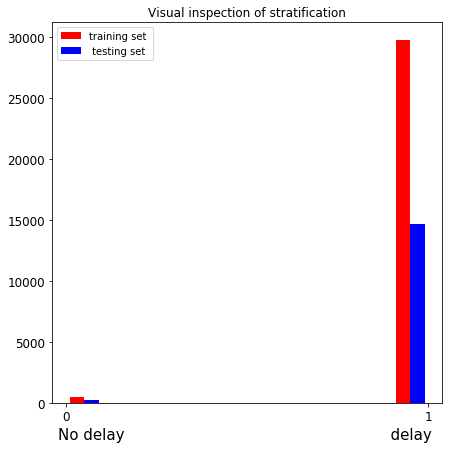

In [27]:
plt.figure(figsize = (7, 7))
matplotlib.rc('xtick', labelsize = 12) 
matplotlib.rc('ytick', labelsize = 12) 
plt.title("Visual inspection of stratification")
plt.xticks([0,1])
plt.xlabel('No delay                                                        delay ', fontsize = 15 )
plt.hist([y_train, y_test], color=['red', 'blue'], label=['training set ',' testing set'])
plt.legend(loc='best')
plt.show()

## Model learning

In [28]:
model = linear_model.LogisticRegression(solver='lbfgs')

In [29]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
model.intercept_

array([8.5299948])

In [31]:
model.coef_

array([[ 4.90790829e-02,  1.25658767e+01,  6.03311894e-02,
        -2.18276782e-03,  4.70885003e-02, -3.05541783e-02,
        -7.86958723e-03, -5.82339156e-02, -2.60995201e-02,
        -2.68324722e-01,  1.66379250e-01, -1.86619328e-01,
         2.52870554e-01,  3.64399362e-02,  3.34655481e-02,
        -1.40924837e-01, -4.81297162e-02,  4.74150376e-02,
        -3.25820731e-02, -3.67521391e-02, -4.32427030e-02,
         5.60851700e-02,  4.84709167e-02, -1.02366586e-01,
         3.55862687e-02, -5.56892492e-02, -3.04213311e-02]])

## Evaluation

In [32]:
y_test_predicted = model.predict(X_test)

In [33]:
accuracy = metrics.accuracy_score(y_test, y_test_predicted)
accuracy

0.986343760511268

In [34]:
precision = metrics.precision_score(y_test, y_test_predicted)
precision

0.9868527508090615

In [35]:
recall = metrics.recall_score(y_test, y_test_predicted)
recall

0.999453738477296

In [36]:
f1 = metrics.f1_score(y_test, y_test_predicted)
f1

0.99311327475659

In [48]:
metrics.roc_auc_score(y_test, y_test_predicted)

0.5565450510568298

In [49]:
# metrics.plot_roc_curve(logistic_regression, X_test, y_test)

In [50]:
y_train_predicted = model.predict(X_train)

In [51]:
y_train_predicted[:30]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [52]:
train_score = metrics.accuracy_score(y_train, y_train_predicted)
test_score = metrics.accuracy_score(y_test, y_test_predicted)

In [53]:
print("Accuracy at the training set: {train}\nAccuracy at the test set: {test}".format(train=train_score, test=test_score))

Accuracy at the training set: 0.9867126147320985
Accuracy at the test set: 0.986343760511268


In [54]:
print(metrics.classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.76      0.11      0.20       220
           1       0.99      1.00      0.99     14645

    accuracy                           0.99     14865
   macro avg       0.87      0.56      0.60     14865
weighted avg       0.98      0.99      0.98     14865



In [55]:
metrics.confusion_matrix(y_test, y_test_predicted)

array([[   25,   195],
       [    8, 14637]], dtype=int64)

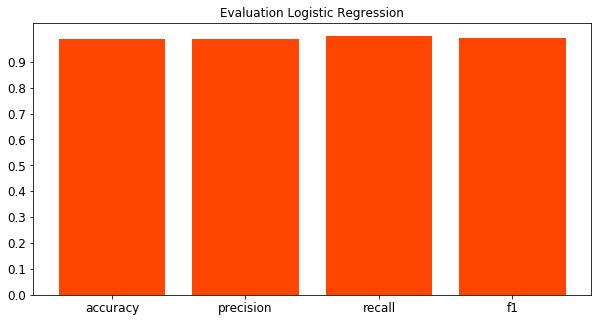

In [56]:
fig = plt.figure(figsize=(10, 5))
plt.bar(['accuracy', 'precision', 'recall', 'f1'], [accuracy , precision, recall, f1], color='orangered')
plt.title("Evaluation Logistic Regression")
plt.yticks(np.arange(0, 1, 0.1)) 
plt.show()

# Neural networks

In [57]:
np.random.seed(7)

## Creating Neural networks

I will create a neural network with advance propagation. <br> The neural network will have an input layer, three hidden layers with, respectively, 100, 40 and 20 neurons, and an output layer. <br> The number of input layer neurons corresponds to the number of attributes of the data set, which is 27. <br> The number of output layer neurons is 1 since it is a binary classification. <br> In hidden layers I will use relu activation function and in the latter sigmoid function. <br> Optimizer Adam will be used. <br> Binary cross entropy as a function of error will be used. <br> Since the task of classification metrics will be accuracy. <br> I will use Dropout regularization for reducing overfitting and improving the generalization. 

In [58]:
number_of_features = X_train.shape[1]
output_size = 1

In [59]:
number_of_features

27

In [60]:
model = Sequential()
model.add(Dense(units = 100, input_dim = number_of_features, activation = 'relu'))
model.add(Dense(units = 40, activation = 'relu'))
model.add(Dense(units = 20, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units = output_size, activation = 'sigmoid'))

In [61]:
model.compile( optimizers.Adam(learning_rate = 0.0001), loss = losses.BinaryCrossentropy(), metrics = ['accuracy'] )

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2800      
_________________________________________________________________
dense_1 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 7,681
Trainable params: 7,681
Non-trainable params: 0
_________________________________________________________________


In [63]:
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, verbose = 1, validation_split = 0.2)

Epoch 1/50
755/755 [==============================] - 4s 6ms/step - loss: 0.2035 - accuracy: 0.9525 - val_loss: 0.0819 - val_accuracy: 0.9853
Epoch 2/50
755/755 [==============================] - 4s 5ms/step - loss: 0.0831 - accuracy: 0.9851 - val_loss: 0.0755 - val_accuracy: 0.9853
Epoch 3/50
755/755 [==============================] - 4s 5ms/step - loss: 0.0777 - accuracy: 0.9851 - val_loss: 0.0724 - val_accuracy: 0.9853
Epoch 4/50
755/755 [==============================] - 4s 5ms/step - loss: 0.0757 - accuracy: 0.9851 - val_loss: 0.0704 - val_accuracy: 0.9853
Epoch 5/50
755/755 [==============================] - 4s 5ms/step - loss: 0.0718 - accuracy: 0.9851 - val_loss: 0.0690 - val_accuracy: 0.9853
Epoch 6/50
755/755 [==============================] - 4s 6ms/step - loss: 0.0697 - accuracy: 0.9851 - val_loss: 0.0668 - val_accuracy: 0.9853
Epoch 7/50
755/755 [==============================] - 4s 5ms/step - loss: 0.0677 - accuracy: 0.9851 - val_loss: 0.0651 - val_accuracy: 0.9853
Epoch 

In [64]:
epochs = history.epoch

loss = history.history['loss']
validation_loss = history.history['val_loss']

acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

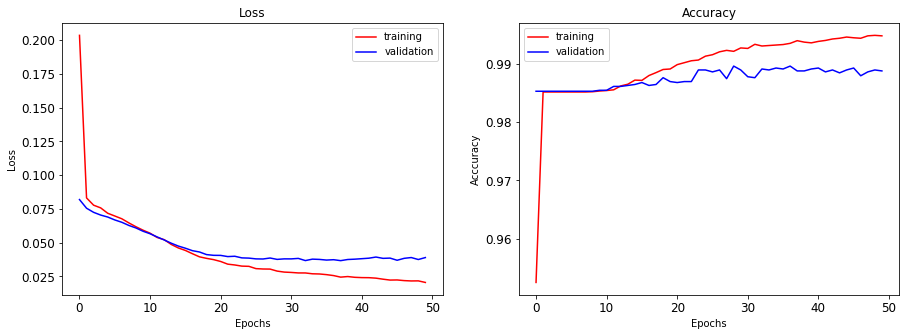

In [65]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, c='red', label='training')
plt.plot(epochs, validation_loss, c='blue', label='validation')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acccuracy')
plt.plot(epochs, acc, c='red', label='training')
plt.plot(epochs, validation_acc, c='blue', label='validation')
plt.legend(loc='best')

## Neural network evaluation

In [66]:
final_model = Sequential()
final_model.add(Dense(units=100, input_dim=number_of_features, activation='relu'))
final_model.add(Dense(units=40, activation='relu'))
final_model.add(Dense(units=20, activation='relu'))
final_model.add(Dropout(0.1))
final_model.add(Dense(units=output_size, activation='sigmoid'))
final_model.compile(optimizers.Adam(learning_rate = 0.0001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

In [67]:
history = final_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose = 1)

Epoch 1/50
944/944 [==============================] - 5s 5ms/step - loss: 0.2340 - accuracy: 0.9067
Epoch 2/50
944/944 [==============================] - 5s 5ms/step - loss: 0.0813 - accuracy: 0.9852
Epoch 3/50
944/944 [==============================] - 5s 5ms/step - loss: 0.0752 - accuracy: 0.9852
Epoch 4/50
944/944 [==============================] - 4s 5ms/step - loss: 0.0724 - accuracy: 0.9852
Epoch 5/50
944/944 [==============================] - 5s 5ms/step - loss: 0.0688 - accuracy: 0.9852
Epoch 6/50
944/944 [==============================] - 4s 5ms/step - loss: 0.0655 - accuracy: 0.9852
Epoch 7/50
944/944 [==============================] - 4s 4ms/step - loss: 0.0630 - accuracy: 0.9852
Epoch 8/50
944/944 [==============================] - 5s 5ms/step - loss: 0.0606 - accuracy: 0.9854
Epoch 9/50
944/944 [==============================] - 5s 6ms/step - loss: 0.0570 - accuracy: 0.9856
Epoch 10/50
944/944 [==============================] - 4s 4ms/step - loss: 0.0541 - accuracy: 0.9861

In [68]:
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)
print ("Test loss: {}, test accuracy: {}".format(test_loss, test_accuracy))

465/465 [==============================] - 1s 3ms/step - loss: 0.0350 - accuracy: 0.9886
Test loss: 0.03500482067465782, test accuracy: 0.988631010055542


In [69]:
train_loss, train_accuracy = final_model.evaluate(X_train, y_train)
print ("Train loss: {}, train accuracy: {}".format(train_loss, train_accuracy))

944/944 [==============================] - 3s 3ms/step - loss: 0.0170 - accuracy: 0.9963
Train loss: 0.016966216266155243, train accuracy: 0.9962556958198547


In [70]:
epochs = history.epoch
loss = history.history['loss']
acc = history.history['accuracy']

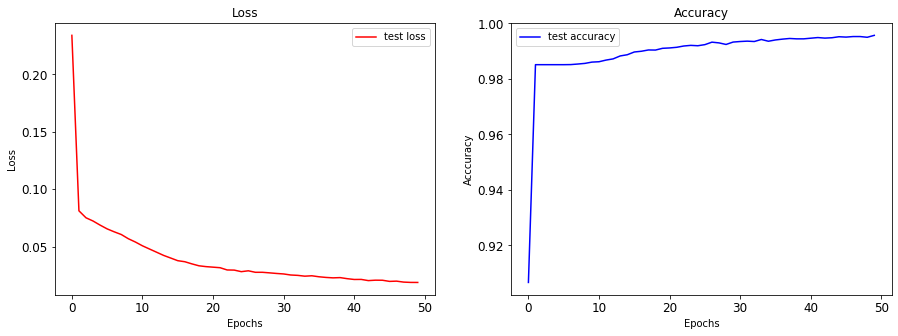

In [71]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, c='red', label='test loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acccuracy')
plt.plot(epochs, acc, c='blue', label = 'test accuracy')
plt.legend(loc='best')

### Oversampling 
Since the data is not balanced I will do Oversampling

In [87]:
wd = np.sum(y == 0)
d = np.sum(y == 1)
print('With Delay: ', d , '     Without Delay: ', wd)

With Delay:  44376      Without Delay:  668


In [88]:
y.value_counts()

1    44376
0      668
Name: Delay, dtype: int64

In [89]:
X

,Route,Min Gap,Vehicle,Direction_e,Direction_n,Direction_s,Direction_w,Incident_Diversion,Incident_Emergency Services,Incident_General Delay,...,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Year,Month,Day,Hour
0,505,8,4018,1,0,0,0,0,0,0,...,0,0,0,1,0,0,2014,1,2,6
1,504,22,4128,1,0,0,0,0,0,0,...,0,0,0,1,0,0,2014,1,2,12
2,501,19,4016,0,0,0,1,0,0,0,...,0,0,0,1,0,0,2014,1,2,14
3,504,11,4175,0,0,0,1,0,0,0,...,0,0,0,1,0,0,2014,1,2,14
4,504,6,4080,1,0,0,0,0,0,0,...,0,0,0,1,0,0,2014,1,2,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45039,505,16,4164,1,0,0,0,0,0,0,...,0,0,1,0,0,0,2017,12,31,9
45040,501,24,4110,0,0,0,1,0,0,0,...,0,0,1,0,0,0,2017,12,31,11
45041,501,24,1419,0,0,0,1,0,0,0,...,0,0,1,0,0,0,2017,12,31,11
45042,510,10,4447,0,0,1,0,0,0,0,...,0,0,1,0,0,0,2017,12,31,11


In [266]:
ratio = 1/5
ros = imblearn.over_sampling.RandomOverSampler(random_state = 0, sampling_strategy = ratio)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [267]:
np.bincount(y_resampled)

array([ 8875, 44376], dtype=int64)

In [268]:
wd_resempled = np.sum(y_resampled == 0)
d_resempled = np.sum(y_resampled == 1)
print('With Delay: ', d_resempled, '     Without Delay: ', wd_resempled)

With Delay:  44376      Without Delay:  8875


<BarContainer object of 2 artists>

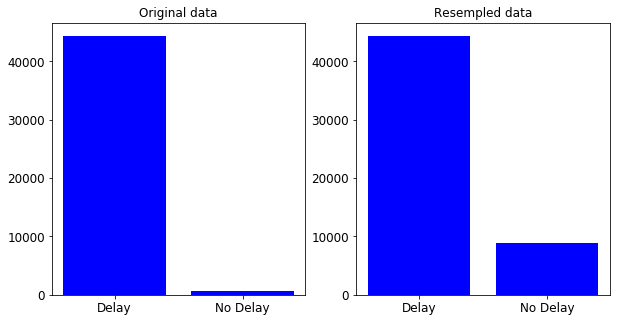

In [269]:
fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original data')
plt.bar(['Delay', 'No Delay'], [d, wd], color='blue')

plt.subplot(1, 2, 2)
plt.title('Resempled data')
plt.bar(['Delay', 'No Delay'], [d_resempled, wd_resempled], color='blue')


# Logistic regression

In [270]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = model_selection.train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 7, stratify = y_resampled)

In [271]:
X_train_resampled.shape

(35678, 27)

In [272]:
X_test_resampled.shape

(17573, 27)

In [273]:
y_train_resampled.shape
    

(35678,)

In [274]:
y_test_resampled.shape

(17573,)

In [275]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_resampled)
X_train_resampled = scaler.transform(X_train_resampled)
X_test_resampled = scaler.transform(X_test_resampled)

In [276]:
wd_train_resampled = np.sum(y_train_resampled == 0)
d_train_resampled = np.sum(y_train_resampled == 1)
print('Train Delay: ', d_train_resampled, '     Train Without Delay: ', wd_train_resampled)

Train Delay:  29732      Train Without Delay:  5946


In [277]:
wd_test_resampled = np.sum(y_test_resampled == 0)
d_test_resampled = np.sum(y_test_resampled == 1)
print('Test Delay: ', d_test_resampled, '     Test Without Delay: ', wd_test_resampled)

Test Delay:  14644      Test Without Delay:  2929


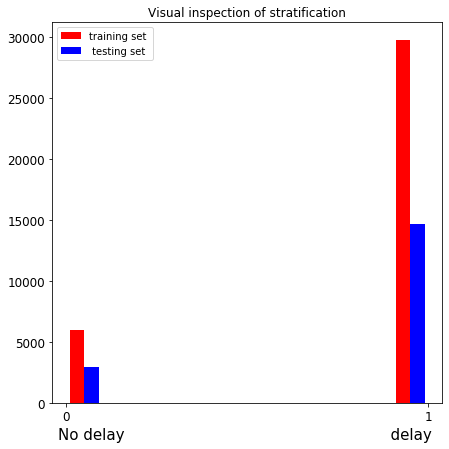

In [278]:
plt.figure(figsize = (7, 7))
matplotlib.rc('xtick', labelsize = 12) 
matplotlib.rc('ytick', labelsize = 12) 
plt.title("Visual inspection of stratification")
plt.xticks([0,1])
plt.xlabel('No delay                                                        delay ', fontsize = 15 )
plt.hist([y_train_resampled, y_test_resampled], color=['red', 'blue'], label=['training set ',' testing set'])
plt.legend(loc='best')
plt.show()

## Model learning

In [279]:
model = linear_model.LogisticRegression(solver='lbfgs')

In [280]:
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [281]:
model.intercept_

array([5.17079354])

In [282]:
model.coef_

array([[ 6.29778981e-02,  1.14708951e+01,  6.54499330e-03,
         3.59551197e-02, -1.87756874e-02, -1.28568840e-02,
        -1.74796787e-02, -1.28943430e-01, -1.61475341e-01,
        -2.27560366e-01,  1.01563319e-01, -1.53148182e-01,
         2.21024398e-01,  1.13971104e-01,  6.97216797e-02,
        -4.28198903e-02, -2.49722580e-02,  4.31955716e-02,
        -8.02504304e-02, -8.25125542e-02,  5.19182504e-03,
         2.71542884e-02,  8.95223396e-02, -1.52333597e-01,
         1.25583904e-02, -3.70282856e-03, -6.55845703e-03]])

## Evaluation

In [283]:
y_test_predicted = model.predict(X_test_resampled)

In [284]:
accuracy  = metrics.accuracy_score(  y_test_resampled, y_test_predicted )
precision = metrics.precision_score( y_test_resampled, y_test_predicted )
recall    = metrics.recall_score(    y_test_resampled, y_test_predicted )
f1        = metrics.f1_score(        y_test_resampled, y_test_predicted )

In [332]:
print("Accuracy  = " ,  accuracy)
print("Precision = " , precision )
print("Recall    = " , recall )
print("F1        = " , f1 )

Accuracy  =  0.9676207818812952
Precision =  0.9802770763666143
Recall    =  0.9808795411089866
F1        =  0.9805782161996109


In [286]:
y_train_predicted = model.predict(X_train_resampled)

In [287]:
y_train_predicted[:30]

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1], dtype=int64)

In [288]:
train_score = metrics.accuracy_score(y_train_resampled, y_train_predicted)
test_score  = metrics.accuracy_score(y_test_resampled,  y_test_predicted)

In [334]:
print("Accuracy at the training set: {train}\nAccuracy at the test set:     {test}".format(train=train_score, test=test_score))

Accuracy at the training set: 0.9665339985425192
Accuracy at the test set:     0.9676207818812952


In [335]:
print(metrics.classification_report(y_test_resampled, y_test_predicted))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2929
           1       0.98      0.98      0.98     14644

    accuracy                           0.97     17573
   macro avg       0.94      0.94      0.94     17573
weighted avg       0.97      0.97      0.97     17573



In [336]:
metrics.confusion_matrix(y_test_resampled, y_test_predicted)

array([[ 2640,   289],
       [  280, 14364]], dtype=int64)

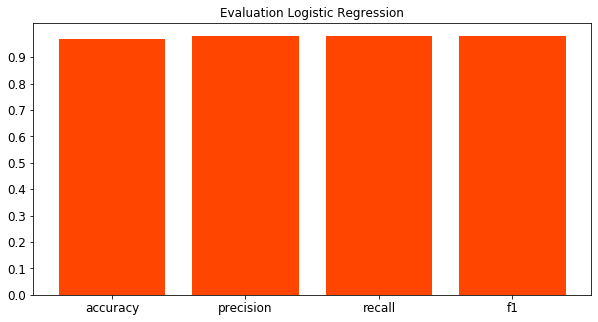

In [337]:
fig = plt.figure(figsize=(10, 5))
plt.bar(['accuracy', 'precision', 'recall', 'f1'], [accuracy , precision, recall, f1], color='orangered')
plt.title("Evaluation Logistic Regression")
plt.yticks(np.arange(0, 1, 0.1)) 
plt.show()

# Neural networks

In [293]:
np.random.seed(7)

## Creating Neural networks

I will create a neural network with advance propagation. <br> The neural network will have an input layer, three hidden layers with, respectively, 100, 40 and 20 neurons, and an output layer. <br> The number of input layer neurons corresponds to the number of attributes of the data set, which is 27. <br> The number of output layer neurons is 1 since it is a binary classification. <br> In hidden layers I will use relu activation function and in the latter sigmoid function. <br> Optimizer Adam will be used. <br> Binary cross entropy as a function of error will be used. <br> Since the task of classification metrics will be accuracy. <br> I will use Dropout regularization for reducing overfitting and improving the generalization. 

In [294]:
number_of_features = X_train.shape[1]
output_size = 1

In [295]:
number_of_features

27

In [296]:
model = Sequential()
model.add(Dense(units = 100, input_dim = number_of_features, activation = 'relu'))
model.add(Dense(units = 40, activation = 'relu'))
model.add(Dense(units = 20, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units = output_size, activation = 'sigmoid'))

In [297]:
model.compile( optimizers.Adam(learning_rate = 0.0001), loss = losses.BinaryCrossentropy(), metrics = ['accuracy'] )

In [298]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               2800      
_________________________________________________________________
dense_21 (Dense)             (None, 40)                4040      
_________________________________________________________________
dense_22 (Dense)             (None, 20)                820       
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 21        
Total params: 7,681
Trainable params: 7,681
Non-trainable params: 0
_________________________________________________________________


In [299]:
history = model.fit(X_train_resampled, y_train_resampled, epochs = 50, batch_size = 32, verbose = 1, validation_split = 0.2)

Epoch 1/50
892/892 [==============================] - 5s 6ms/step - loss: 0.4369 - accuracy: 0.8294 - val_loss: 0.3813 - val_accuracy: 0.8384
Epoch 2/50
892/892 [==============================] - 4s 5ms/step - loss: 0.3520 - accuracy: 0.8522 - val_loss: 0.3131 - val_accuracy: 0.8648
Epoch 3/50
892/892 [==============================] - 4s 5ms/step - loss: 0.2748 - accuracy: 0.8910 - val_loss: 0.2345 - val_accuracy: 0.9177
Epoch 4/50
892/892 [==============================] - 4s 5ms/step - loss: 0.2087 - accuracy: 0.9371 - val_loss: 0.1891 - val_accuracy: 0.9469
Epoch 5/50
892/892 [==============================] - 4s 5ms/step - loss: 0.1727 - accuracy: 0.9553 - val_loss: 0.1618 - val_accuracy: 0.9577
Epoch 6/50
892/892 [==============================] - 5s 5ms/step - loss: 0.1526 - accuracy: 0.9624 - val_loss: 0.1460 - val_accuracy: 0.9636
Epoch 7/50
892/892 [==============================] - 5s 5ms/step - loss: 0.1390 - accuracy: 0.9662 - val_loss: 0.1365 - val_accuracy: 0.9662
Epoch 

In [300]:
epochs = history.epoch

loss = history.history['loss']
validation_loss = history.history['val_loss']

acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

In [338]:
print("Loss                = " , loss[49] )
print("Accuracy            = " ,  acc[49])

print("Validation Loss     = " , validation_loss[49] )
print("Validation Accuracy = " ,  validation_acc[49])

Loss                =  0.021288786083459854
Accuracy            =  0.9935254454612732
Validation Loss     =  0.046979885548353195
Validation Accuracy =  0.9854260087013245


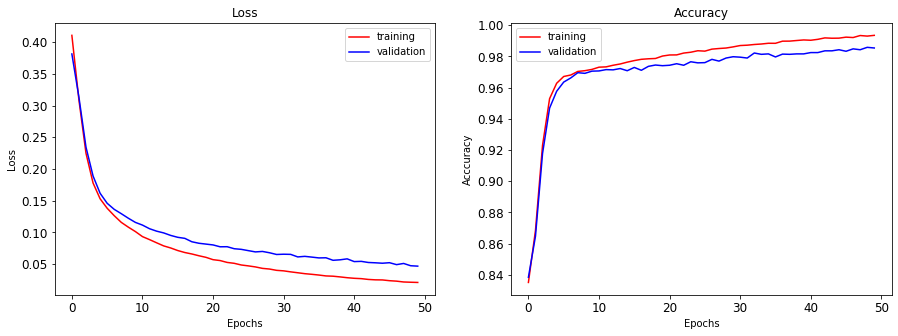

In [339]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, c='red', label='training')
plt.plot(epochs, validation_loss, c='blue', label='validation')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acccuracy')
plt.plot(epochs, acc, c='red', label='training')
plt.plot(epochs, validation_acc, c='blue', label='validation')
plt.legend(loc='best')

## Neural network evaluation

In [308]:
final_model = Sequential()
final_model.add(Dense(units=100, input_dim=number_of_features, activation='relu'))
final_model.add(Dense(units=40, activation='relu'))
final_model.add(Dense(units=20, activation='relu'))
final_model.add(Dropout(0.1))
final_model.add(Dense(units=output_size, activation='sigmoid'))
final_model.compile(optimizers.Adam(learning_rate = 0.0001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

In [344]:
history = final_model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, verbose = 1)

Epoch 1/50
1115/1115 [==============================] - 5s 5ms/step - loss: 0.0204 - accuracy: 0.9935
Epoch 2/50
1115/1115 [==============================] - 5s 4ms/step - loss: 0.0198 - accuracy: 0.9940
Epoch 3/50
1115/1115 [==============================] - 5s 4ms/step - loss: 0.0194 - accuracy: 0.9937
Epoch 4/50
1115/1115 [==============================] - 5s 5ms/step - loss: 0.0190 - accuracy: 0.9942
Epoch 5/50
1115/1115 [==============================] - 6s 5ms/step - loss: 0.0184 - accuracy: 0.9944
Epoch 6/50
1115/1115 [==============================] - 5s 5ms/step - loss: 0.0176 - accuracy: 0.9942
Epoch 7/50
1115/1115 [==============================] - 6s 5ms/step - loss: 0.0173 - accuracy: 0.9948
Epoch 8/50
1115/1115 [==============================] - 6s 5ms/step - loss: 0.0169 - accuracy: 0.9951
Epoch 9/50
1115/1115 [==============================] - 5s 5ms/step - loss: 0.0161 - accuracy: 0.9948
Epoch 10/50
1115/1115 [==============================] - 6s 6ms/step - loss: 0.015

In [345]:
test_loss, test_accuracy = final_model.evaluate(X_test_resampled, y_test_resampled)
print ("Test loss:     {}, \nTest accuracy: {}".format(test_loss, test_accuracy))

550/550 [==============================] - 2s 3ms/step - loss: 0.0458 - accuracy: 0.9900
Test loss:     0.04578455537557602, 
Test accuracy: 0.9900415539741516


In [346]:
train_loss, train_accuracy = final_model.evaluate(X_train_resampled, y_train_resampled)
print ("Train loss:     {}, \nTrain accuracy: {}".format(train_loss, train_accuracy))

1115/1115 [==============================] - 4s 3ms/step - loss: 0.0057 - accuracy: 0.9983
Train loss:     0.0056786625646054745, 
Train accuracy: 0.9982902407646179


In [347]:
epochs = history.epoch
loss = history.history['loss']
acc = history.history['accuracy']

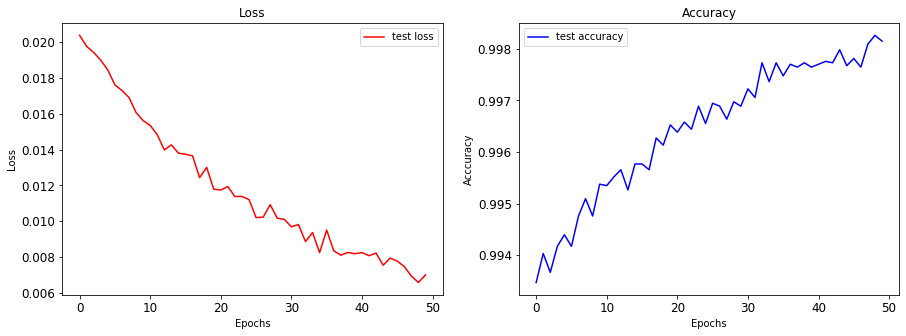

In [354]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, c='red', label='test loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acccuracy')
plt.plot(epochs, acc , c='blue', label = 'test accuracy')
plt.legend(loc='best')



## Save model

In [349]:
from keras.models import load_model

In [350]:
model.save('final_model.h5') 